# NYC Taxi Fare Prediction

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import lightgbm as lgbm
import xgboost as xgb

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf


In [2]:
df = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/train.csv', nrows = 4000000)
test_df = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv')
df.shape, test_df.shape

((4000000, 8), (9914, 7))

In [3]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
df.isnull().sum().sort_index()/len(df)

dropoff_latitude     0.000007
dropoff_longitude    0.000007
fare_amount          0.000000
key                  0.000000
passenger_count      0.000000
pickup_datetime      0.000000
pickup_latitude      0.000000
pickup_longitude     0.000000
dtype: float64

In [5]:
df.dropna(subset=['dropoff_latitude', 'dropoff_longitude'], inplace = True)

In [6]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,3.999971e+06,3.999971e+06,3.999971e+06,3.999971e+06,3.999971e+06,3.999971e+06
mean,1.134389e+01,-7.250845e+01,3.991910e+01,-7.250871e+01,3.991789e+01,1.684346e+00
std,9.824417e+00,1.312180e+01,8.797877e+00,1.289308e+01,9.716855e+00,1.329068e+00
min,-6.200000e+01,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076711e+01,-7.396366e+01,4.076812e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,2.912465e+03,3.457622e+03,3.345917e+03,2.080000e+02


In [7]:
df.drop(df[df['fare_amount'] < 2.5].index, axis=0, inplace = True)
df.drop(df[df['fare_amount'] > 500].index, axis=0, inplace = True)

In [8]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [9]:
df[df['passenger_count'] > 5].sort_values('passenger_count')

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
38,2013-11-24 11:42:00.000000113,9.00,2013-11-24 11:42:00 UTC,-73.957740,40.773617,-73.977087,40.758465,6
2669691,2009-05-30 10:41:00.00000024,49.15,2009-05-30 10:41:00 UTC,-73.780313,40.645430,-73.980503,40.760318,6
2669688,2013-06-15 05:51:00.00000012,4.50,2013-06-15 05:51:00 UTC,-74.002810,40.733927,-74.006502,40.737720,6
2669559,2014-12-21 13:54:00.000000191,30.00,2014-12-21 13:54:00 UTC,-73.862770,40.768960,-73.762060,40.764840,6
2669486,2014-08-01 21:33:00.000000142,29.00,2014-08-01 21:33:00 UTC,-73.960020,40.773450,-73.845380,40.721610,6
...,...,...,...,...,...,...,...,...
929022,2009-07-30 11:54:00.000000193,3.30,2009-07-30 11:54:00 UTC,0.000000,0.000000,0.000000,0.000000,208
2910347,2010-12-16 06:44:00.00000039,4.50,2010-12-16 06:44:00 UTC,0.000000,0.000000,0.000000,0.000000,208
3107489,2009-05-12 14:50:00.000000175,2.70,2009-05-12 14:50:00 UTC,-73.937818,40.758260,-73.937827,40.758250,208
2154045,2010-12-16 11:21:00.000000209,3.30,2010-12-16 11:21:00 UTC,0.000000,0.000000,0.000000,0.000000,208


In [10]:
df.drop(df[df['pickup_longitude'] == 0].index, axis=0, inplace = True)
df.drop(df[df['pickup_latitude'] == 0].index, axis=0, inplace = True)
df.drop(df[df['dropoff_longitude'] == 0].index, axis=0, inplace = True)
df.drop(df[df['dropoff_latitude'] == 0].index, axis=0, inplace = True)
df.drop(df[df['passenger_count'] == 208].index, axis=0, inplace = True)

In [11]:
df['key'] = pd.to_datetime(df['key'])
key = test_df.key
test_df['key'] = pd.to_datetime(test_df['key'])
df['pickup_datetime']  = pd.to_datetime(df['pickup_datetime'])
test_df['pickup_datetime']  = pd.to_datetime(test_df['pickup_datetime'])

In [12]:
df['Year'] = df['pickup_datetime'].dt.year
df['Month'] = df['pickup_datetime'].dt.month
df['Date'] = df['pickup_datetime'].dt.day
df['Day of Week'] = df['pickup_datetime'].dt.dayofweek
df['Hour'] = df['pickup_datetime'].dt.hour
df.drop('pickup_datetime', axis = 1, inplace = True)
df.drop('key', axis = 1, inplace = True)

test_df['Year'] = test_df['pickup_datetime'].dt.year
test_df['Month'] = test_df['pickup_datetime'].dt.month
test_df['Date'] = test_df['pickup_datetime'].dt.day
test_df['Day of Week'] = test_df['pickup_datetime'].dt.dayofweek
test_df['Hour'] = test_df['pickup_datetime'].dt.hour
test_df.drop('pickup_datetime', axis = 1, inplace = True)
test_df.drop('key', axis = 1, inplace = True)

In [13]:
df.dropna(inplace=True)

df.drop(df.index[(df.pickup_longitude < -75) | 
           (df.pickup_longitude > -72) | 
           (df.pickup_latitude < 40) | 
           (df.pickup_latitude > 42)],inplace=True)
df.drop(df.index[(df.dropoff_longitude < -75) | 
           (df.dropoff_longitude > -72) | 
           (df.dropoff_latitude < 40) | 
           (df.dropoff_latitude > 42)],inplace=True)

In [14]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day of Week,Hour
count,3.915543e+06,3.915543e+06,3.915543e+06,3.915543e+06,3.915543e+06,3.915543e+06,3.915543e+06,3.915543e+06,3.915543e+06,3.915543e+06,3.915543e+06
mean,1.132662e+01,-7.397517e+01,4.075104e+01,-7.397431e+01,4.075141e+01,1.684201e+00,2.011736e+03,6.268611e+00,1.571538e+01,3.041275e+00,1.351376e+01
std,9.709136e+00,3.917861e-02,3.007927e-02,3.831200e-02,3.322418e-02,1.308739e+00,1.862858e+00,3.436337e+00,8.685053e+00,1.949656e+00,6.514405e+00
min,2.500000e+00,-7.498856e+01,4.005272e+01,-7.499828e+01,4.000565e+01,0.000000e+00,2.009000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,-7.399228e+01,4.073655e+01,-7.399158e+01,4.073558e+01,1.000000e+00,2.010000e+03,3.000000e+00,8.000000e+00,1.000000e+00,9.000000e+00
50%,8.500000e+00,-7.398210e+01,4.075334e+01,-7.398061e+01,4.075386e+01,1.000000e+00,2.012000e+03,6.000000e+00,1.600000e+01,3.000000e+00,1.400000e+01
75%,1.250000e+01,-7.396833e+01,4.076754e+01,-7.396535e+01,4.076841e+01,2.000000e+00,2.013000e+03,9.000000e+00,2.300000e+01,5.000000e+00,1.900000e+01
max,5.000000e+02,-7.206320e+01,4.192279e+01,-7.219609e+01,4.199811e+01,1.290000e+02,2.015000e+03,1.200000e+01,3.100000e+01,6.000000e+00,2.300000e+01


In [15]:
import geopy.distance

def geodesic_dist(trip):
    pickup_lat = trip['pickup_latitude']
    pickup_long = trip['pickup_longitude']
    dropoff_lat = trip['dropoff_latitude']
    dropoff_long = trip['dropoff_longitude']
    distance = geopy.distance.geodesic((pickup_lat, pickup_long), 
                                       (dropoff_lat, dropoff_long)).miles
    try:
        return distance
    except ValueError:
        return np.nan
    
def circle_dist(trip):
    pickup_lat = trip['pickup_latitude']
    pickup_long = trip['pickup_longitude']
    dropoff_lat = trip['dropoff_latitude']
    dropoff_long = trip['dropoff_longitude']
    distance = geopy.distance.great_circle((pickup_lat, pickup_long), 
                                       (dropoff_lat, dropoff_long)).miles
    try:
        return distance
    except ValueError:
        return np.nan

In [16]:
def jfk_dist(trip):
    jfk_lat = 40.6413
    jfk_long = -73.7781
    dropoff_lat = trip['dropoff_latitude']
    dropoff_long = trip['dropoff_longitude']
    jfk_distance = geopy.distance.geodesic((dropoff_lat, dropoff_long), (jfk_lat, jfk_long)).miles
    return jfk_distance

def lga_dist(trip):
    lga_lat = 40.7769
    lga_long = -73.8740
    dropoff_lat = trip['dropoff_latitude']
    dropoff_long = trip['dropoff_longitude']
    lga_distance = geopy.distance.geodesic((dropoff_lat, dropoff_long), (lga_lat, lga_long)).miles
    return lga_distance

def ewr_dist(trip):
    ewr_lat = 40.6895
    ewr_long = -74.1745
    dropoff_lat = trip['dropoff_latitude']
    dropoff_long = trip['dropoff_longitude']
    ewr_distance = geopy.distance.geodesic((dropoff_lat, dropoff_long), (ewr_lat, ewr_long)).miles
    return ewr_distance

def tsq_dist(trip):
    tsq_lat = 40.7580
    tsq_long = -73.9855
    dropoff_lat = trip['dropoff_latitude']
    dropoff_long = trip['dropoff_longitude']
    tsq_distance = geopy.distance.geodesic((dropoff_lat, dropoff_long), (tsq_lat, tsq_long)).miles
    return tsq_distance

def cpk_dist(trip):
    cpk_lat = 40.7812
    cpk_long = -73.9665
    dropoff_lat = trip['dropoff_latitude']
    dropoff_long = trip['dropoff_longitude']
    cpk_distance = geopy.distance.geodesic((dropoff_lat, dropoff_long), (cpk_lat, cpk_long)).miles
    return cpk_distance

def lib_dist(trip):
    lib_lat = 40.6892
    lib_long = -74.0445
    dropoff_lat = trip['dropoff_latitude']
    dropoff_long = trip['dropoff_longitude']
    lib_distance = geopy.distance.geodesic((dropoff_lat, dropoff_long), (lib_lat, lib_long)).miles
    return lib_distance

def gct_dist(trip):
    gct_lat = 40.7527
    gct_long = -73.9772
    dropoff_lat = trip['dropoff_latitude']
    dropoff_long = trip['dropoff_longitude']
    gct_distance = geopy.distance.geodesic((dropoff_lat, dropoff_long), (gct_lat, gct_long)).miles
    return gct_distance

def met_dist(trip):
    met_lat = 40.7794
    met_long = -73.9632
    dropoff_lat = trip['dropoff_latitude']
    dropoff_long = trip['dropoff_longitude']
    met_distance = geopy.distance.geodesic((dropoff_lat, dropoff_long), (met_lat, met_long)).miles
    return met_distance

def wtc_dist(trip):
    wtc_lat = 40.7126
    wtc_long = -74.0099
    dropoff_lat = trip['dropoff_latitude']
    dropoff_long = trip['dropoff_longitude']
    wtc_distance = geopy.distance.geodesic((dropoff_lat, dropoff_long), (wtc_lat, wtc_long)).miles
    return wtc_distance

In [17]:
def optimize_floats(df):
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df


def optimize_ints(df):
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df

def optimize(df):
    return optimize_floats(optimize_ints(df))

In [18]:
df = optimize(df)
test_df = optimize(test_df)

In [19]:
def calc_dists(df):
    df['geodesic'] = df.apply(lambda x: geodesic_dist(x), axis = 1 )
    df['circle'] = df.apply(lambda x: circle_dist(x), axis = 1 )
    df['jfk'] = df.apply(lambda x: jfk_dist(x), axis = 1 )
    df['lga'] = df.apply(lambda x: lga_dist(x), axis = 1 )
    df['ewr'] = df.apply(lambda x: ewr_dist(x), axis = 1 )
    df['tsq'] = df.apply(lambda x: tsq_dist(x), axis = 1 )
    df['cpk'] = df.apply(lambda x: cpk_dist(x), axis = 1 )
    df['lib'] = df.apply(lambda x: lib_dist(x), axis = 1 )
    df['gct'] = df.apply(lambda x: gct_dist(x), axis = 1 )
    df['met'] = df.apply(lambda x: met_dist(x), axis = 1 )
    df['wtc'] = df.apply(lambda x: wtc_dist(x), axis = 1 )
    return df

In [20]:
df = calc_dists(df)
test_df = calc_dists(test_df)

In [21]:
# df.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1,inplace=True)
# test_df.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis=1,inplace=True)

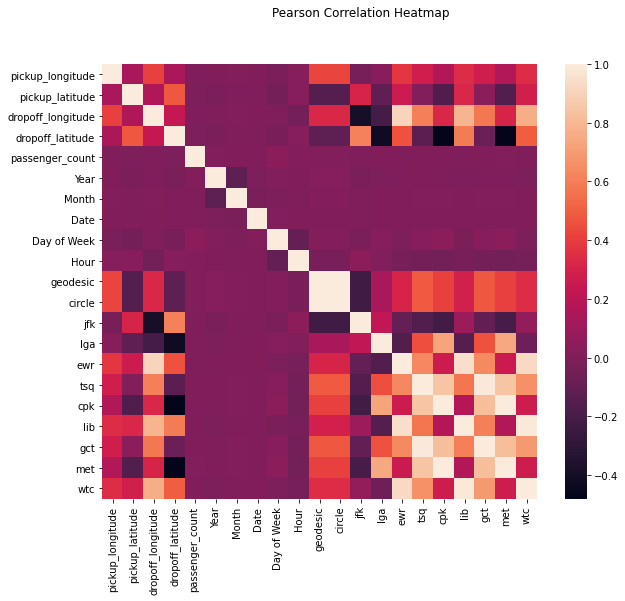

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop('fare_amount', axis=1).corr(), square=True)
plt.suptitle('Pearson Correlation Heatmap')
plt.show();

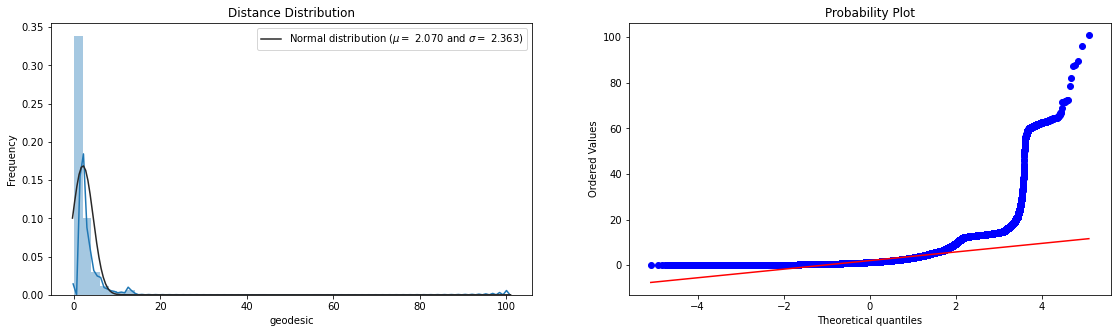

In [23]:
(mu, sigma) = norm.fit(df['geodesic'])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 5))
ax1 = sns.distplot(df['geodesic'] , fit=norm, ax=ax1)
ax1.legend([f'Normal distribution ($\mu=$ {mu:.3f} and $\sigma=$ {sigma:.3f})'], loc='best')
ax1.set_ylabel('Frequency')
ax1.set_title('Distance Distribution')
ax2 = stats.probplot(df['geodesic'], plot=plt)
f.show();

In [24]:
df[df['geodesic'] > 100].sort_values('passenger_count')

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day of Week,...,circle,jfk,lga,ewr,tsq,cpk,lib,gct,met,wtc
1937753,20.5,-72.063202,40.834679,-73.982452,40.772621,2,2015,5,8,4,...,100.467284,14.044726,5.696716,11.59823,1.021493,1.025003,6.613799,1.401967,1.112967,4.384979


In [25]:
df.drop(df[df['geodesic'] > 100].index, axis=0, inplace = True)

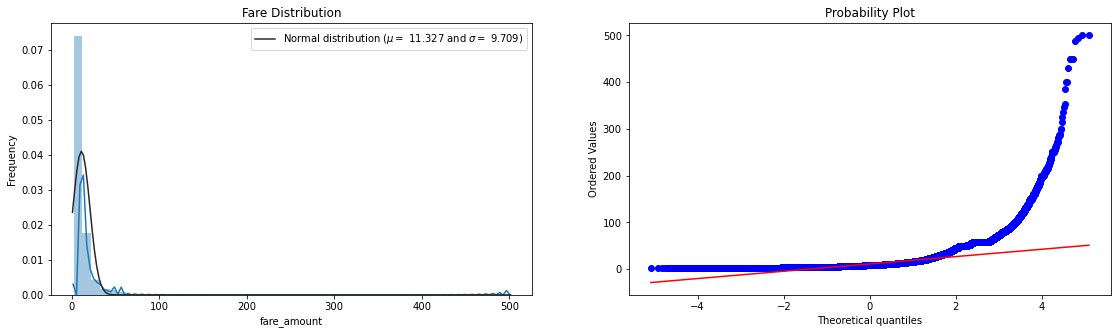

In [26]:
(mu, sigma) = norm.fit(df['fare_amount'])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 5))
ax1 = sns.distplot(df['fare_amount'] , fit=norm, ax=ax1)
ax1.legend([f'Normal distribution ($\mu=$ {mu:.3f} and $\sigma=$ {sigma:.3f})'], loc='best')
ax1.set_ylabel('Frequency')
ax1.set_title('Fare Distribution')
ax2 = stats.probplot(df['fare_amount'], plot=plt)
f.show();

In [27]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,Date,Day of Week,...,circle,jfk,lga,ewr,tsq,cpk,lib,gct,met,wtc
count,3.915542e+06,3.915542e+06,3.915542e+06,3.915542e+06,3.915542e+06,3.915542e+06,3.915542e+06,3.915542e+06,3.915542e+06,3.915542e+06,...,3.915542e+06,3.915542e+06,3.915542e+06,3.915542e+06,3.915542e+06,3.915542e+06,3.915542e+06,3.915542e+06,3.915542e+06,3.915542e+06
mean,1.130241e+01,-7.492648e+01,4.125544e+01,-7.492591e+01,4.125556e+01,1.684201e+00,2.011736e+03,6.268611e+00,1.571538e+01,3.041275e+00,...,2.069780e+00,1.301821e+01,6.034211e+00,1.151188e+01,2.095550e+00,2.832230e+00,5.933682e+00,2.043798e+00,2.788633e+00,3.710579e+00
std,9.672977e+00,9.577235e-01,5.058470e-01,9.579758e-01,5.058016e-01,1.308739e+00,1.862857e+00,3.436337e+00,8.685053e+00,1.949656e+00,...,2.360049e+00,1.937548e+00,1.917134e+00,2.339737e+00,2.335266e+00,2.379821e+00,2.468732e+00,2.268928e+00,2.363389e+00,2.487976e+00
min,2.500000e+00,-7.498856e+01,4.005272e+01,-7.499828e+01,4.000565e+01,0.000000e+00,2.009000e+03,1.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,9.170678e-02,2.093038e-02,8.390058e-02,1.868764e-04,5.107778e-03,3.057588e-02,9.992924e-04,1.141136e-02,3.259047e-04
25%,6.000000e+00,-7.399228e+01,4.073655e+01,-7.399158e+01,4.073558e+01,1.000000e+00,2.010000e+03,3.000000e+00,8.000000e+00,1.000000e+00,...,7.789772e-01,1.277613e+01,5.182713e+00,1.026711e+01,7.960285e-01,1.343871e+00,4.453508e+00,8.087892e-01,1.327421e+00,2.228826e+00
50%,8.500000e+00,-7.398210e+01,4.075334e+01,-7.398061e+01,4.075386e+01,1.000000e+00,2.012000e+03,6.000000e+00,1.600000e+01,3.000000e+00,...,1.337538e+00,1.318254e+01,5.930927e+00,1.119039e+01,1.557545e+00,2.341990e+00,5.673685e+00,1.542834e+00,2.305464e+00,3.416126e+00
75%,1.250000e+01,-7.396833e+01,4.076754e+01,-7.396535e+01,4.076841e+01,2.000000e+00,2.013000e+03,9.000000e+00,2.300000e+01,5.000000e+00,...,2.430117e+00,1.363309e+01,6.843184e+00,1.232609e+01,2.503976e+00,3.708383e+00,7.029394e+00,2.429734e+00,3.662193e+00,4.752864e+00
max,5.000000e+02,-7.216666e+01,4.192279e+01,-7.219609e+01,4.199811e+01,1.290000e+02,2.015000e+03,1.200000e+01,3.100000e+01,6.000000e+00,...,9.569635e+01,9.932194e+01,9.373068e+01,1.099278e+02,9.898974e+01,9.731025e+01,1.041320e+02,9.880900e+01,9.722530e+01,1.017316e+02


In [28]:
df = optimize(df)
test_df = optimize(test_df)

In [29]:
df.dtypes

fare_amount          float32
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count        int16
Year                   int16
Month                   int8
Date                    int8
Day of Week             int8
Hour                    int8
geodesic             float32
circle               float32
jfk                  float32
lga                  float32
ewr                  float32
tsq                  float32
cpk                  float32
lib                  float32
gct                  float32
met                  float32
wtc                  float32
dtype: object

In [30]:
X, y = df.drop('fare_amount', axis = 1), df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [31]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(test_df)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_params = {
    'min_child_weight': 1, 
    'learning_rate': 0.05, 
    'colsample_bytree': 0.7, 
    'max_depth': 10,
    'subsample': 0.7,
    'n_estimators': 5000,
    'n_jobs': -1, 
    'booster' : 'gbtree', 
    'silent': 1,
    'eval_metric': 'rmse'}

model = xgb.train(xgb_params, dtrain, 500, watchlist, early_stopping_rounds=100, maximize=False, verbose_eval=50)

[18:07:27] WARNING: ../src/learner.cc:516: 
Parameters: { n_estimators, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:13.87647	valid-rmse:13.82956
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[50]	train-rmse:3.73506	valid-rmse:3.87157
[100]	train-rmse:3.37871	valid-rmse:3.63515
[150]	train-rmse:3.24671	valid-rmse:3.59370
[200]	train-rmse:3.16961	valid-rmse:3.57200
[250]	train-rmse:3.10313	valid-rmse:3.54950
[300]	train-rmse:3.05817	valid-rmse:3.53832
[350]	train-rmse:3.01778	valid-rmse:3.53044
[400]	train-rmse:2.98496	valid-rmse:3.52511
[450]	train-rmse:2.95338	valid-rmse:3.52079
[499]	train-rmse:2.92792	valid-rmse:3.51920


In [32]:
y_train_pred = model.predict(dtrain)
y_pred = model.predict(dvalid)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  0.8960480069861874
Test r2 score:  0.867012070011967
Train RMSE: 2.9365
Test RMSE: 3.5208


In [33]:
test_preds = model.predict(dtest)

In [34]:
test_preds = model.predict(dtest)

submission = pd.DataFrame(
    {'key': key, 'fare_amount': test_preds},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission1.csv', index = False)